# **Tesla Stock Forcasting using LSTM and time series analysis**

<img height=1000 width=800 src="https://media.assettype.com/analyticsinsight%2F2024-07%2Fde0d6e57-f6d4-4601-8eed-75279387a41f%2FTesla_Stock_Keeps_Sliding_As_Bears_Target_150___Latest_Price_Forecast_Analysis.jpg?w=640&auto=format%2Ccompress" />

## **Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import math 
from datetime import timedelta


from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error , mean_absolute_error, confusion_matrix 
from sklearn.model_selection import train_test_split 

import keras 
from keras.layers import Dense, Dropout, LSTM 
from keras.callbacks import EarlyStopping 
from keras.models import Sequential 


## **Preprocessing and Visualization**

In [3]:
df = pd.read_csv("/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv", parse_dates=True , index_col="Date")
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [5]:
# Create traces for Open and Close prices
trace_open = go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Open Price')
trace_close = go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close Price')

# Layout settings
layout = go.Layout(
    title='Opening & Closing Price of Tesla',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=[trace_open, trace_close], layout=layout)

# Display the plot
pio.show(fig)

In [6]:
# Create traces for Open and Close prices
volume  = go.Scatter(x=df.index, y=df['Volume'], mode='lines', name='Open Price')


# Layout settings
layout = go.Layout(
    title='Opening & Closing Price of Tesla',
    xaxis_title='Date',
    yaxis_title='Volume',
    legend=dict(x=0, y=1.0),
    margin=dict(l=40, r=40, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=volume, layout=layout)

# Display the plot
pio.show(fig)

In [7]:
df['Daily Return'] = df['Adj Close'].pct_change()

# Create a histogram plot for Daily Return
fig = px.histogram(df, x='Daily Return', nbins=50, title='Tesla Daily Return')

# Update layout for better presentation
fig.update_layout(
    xaxis_title='Daily Return',
    yaxis_title='Frequency',
    height=750,
    width=1000,
    margin=dict(l=100, r=100, t=100, b=100)
)

# Display the plot
fig.show()

In [8]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

In [9]:
df2 = dataset.values
df2.shape

(2956, 1)

## **In time series forecasting, using train_test_split from scikit-learn isn't ideal because it randomly shuffles the data, which disrupts the temporal order of observations. Instead, you often split the data while preserving the time sequence.**

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [11]:
train_size = int( len(df2)*0.75 ) 
test_size = len(df2) - train_size 

print (train_size,"/" ,test_size)

2217 / 739


In [12]:
train_data = data_scaled[:train_size, 0:1] 
test_data = data_scaled[train_size-60:, 0:1] #Why 60 ?

## **Why 60 Additional Points? In time series forecasting, the model often benefits from having access to a certain number of past data points to make predictions. For example, if you want to predict the value of a stock on a given day, you might use the previous 60 days of data to make that prediction.**

In [13]:
train_data.shape , test_data.shape  

((2217, 1), (799, 1))

In [14]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [15]:
# Reshaping the input to 3D array [samples, time_steps, features].
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## **LSTM Mode**

In [16]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    callbacks=[EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)]
)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1357e-04 - mean_absolute_error: 0.0097
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8501e-06 - mean_absolute_error: 0.0018
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8395e-06 - mean_absolute_error: 0.0017
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3098e-06 - mean_absolute_error: 0.0017
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9153e-06 - mean_absolute_error: 0.0018
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8477e-06 - mean_absolute_error: 0.0018
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7706e-06 - mean_absolute_error: 0.0022
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7225e-06 - mean_absolute_error: 0.0020
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2769e-06 - mean_absolute_error: 0.0017
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4738e-06 - mean_absolute_error: 0.001

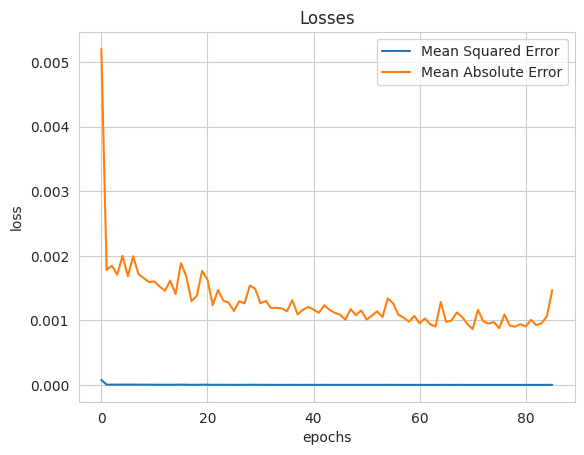

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.title("Losses")
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [20]:

x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [22]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(739, 1)

In [23]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

14.43

In [24]:
# Create traces
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions
fig = go.Figure()

# Plot the training data
fig.add_trace(go.Scatter(x=train.index, y=train['Close'], mode='lines', name='Train', line=dict(width=3)))

# Plot the actual test data
fig.add_trace(go.Scatter(x=test.index, y=test['Close'], mode='lines', name='Test', line=dict(width=3)))

# Plot the predictions
fig.add_trace(go.Scatter(x=test.index, y=test['Predictions'], mode='lines', name='Predictions', line=dict(width=3)))

# Update layout
fig.update_layout(
    title='Tesla Close Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Close Price',
    font=dict(size=18),
    width=1300,
    height=800
)

# Show plot
fig.show()

## **Forcasting of 20 days**

In [25]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [26]:
future = 20
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.7798108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516, 0.73530483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274, 0.6555876]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274, 0.6555876, 0.63204753]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274, 0.6555876, 0.63204753, 0.61097324]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274, 0.6555876, 0.63204753, 0.61097324, 0.5924399]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7798108, 0.7606516, 0.73530483, 0.7082006, 0.68122274, 0.6555876, 0.63204753, 0.61097324, 0.5924

In [27]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [28]:
df_result

,Date,Forecasted
0,2022-03-24,959.792908
1,2022-03-25,936.289368
2,2022-03-26,905.195251
3,2022-03-27,871.945129
4,2022-03-28,838.850037
5,2022-03-29,807.402161
6,2022-03-30,778.524353
7,2022-03-31,752.671448
8,2022-04-01,729.935669
9,2022-04-02,710.154114


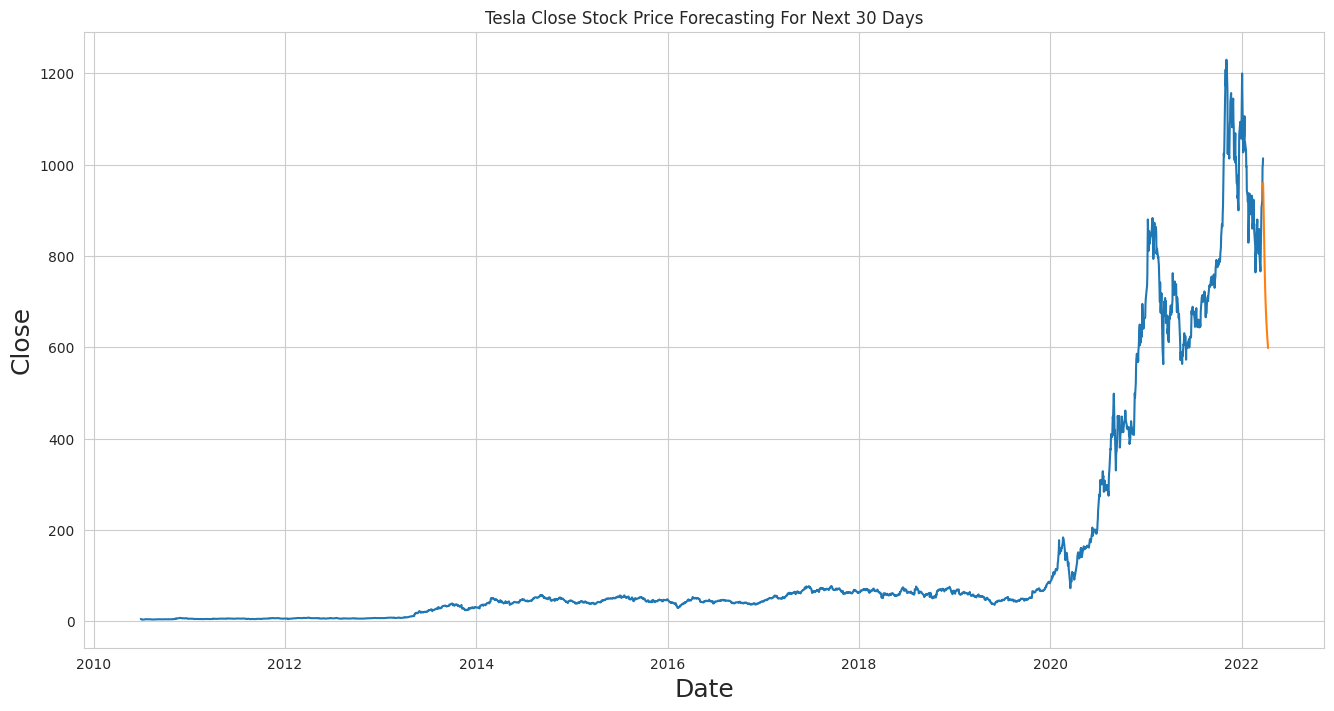

In [29]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])